## Preprocess and explore datasets

#### References
- [Spatial viz and analysis in python](https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf)
- [Getting started with Folium](https://alysivji.github.io/getting-started-with-folium.html)
- [Forecasting at Uber Intro](https://eng.uber.com/forecasting-introduction/)
- [Uber Omphalos](https://eng.uber.com/omphalos/)

## TODOs

- Try fb prophet for time series - only
- Explore spatial econometric methods
- Slice according to percentiles/quartiles to find which can give best results

In [2]:
import pandas as pd
import folium as fol
import geohash2 as gh
import seaborn as sns
import geopandas as gpd
from folium import plugins
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

In [3]:
ds_path = r'C:\Users\jose.luigi.s.torres\Desktop\grabforsea\traffic_management\data\training.csv'

df = pd.read_csv(ds_path)

In [4]:
######### TEST ON SUBSET FIRST #########
subset_test = pd.DataFrame(df.loc[:100,])
decoded = subset_test.geohash6.apply(lambda x: gh.decode_exactly(x))
subset_test['lat'] = decoded.apply(lambda x: x[0])
subset_test['long'] = decoded.apply(lambda x: x[1])

subset_test['hour'] = subset_test.timestamp.str.split(':').str[0]
subset_test['min'] = subset_test.timestamp.str.split(':').str[1]

geom_test = [Point(xy) for xy in zip(subset_test.lat.astype('float'),subset_test.long.astype('float'))]
gdf_test = gpd.GeoDataFrame(subset_test,geometry=geom_test)

subset_test.drop(['geohash6'],axis=1,inplace=True)

In [5]:
# preprocess coordinates
decoded = df.geohash6.apply(lambda x: gh.decode_exactly(x))
df['lat'] = decoded.apply(lambda x: x[0])
df['long'] = decoded.apply(lambda x: x[1])

# convert to geodataframe
geom = [Point(xy) for xy in zip(df.lat.astype('float'),df.long.astype('float'))]
gdf = gpd.GeoDataFrame(df,geometry=geom)

In [6]:
gdf['hour'] = gdf.timestamp.str.split(':').str[0]
gdf['min'] = gdf.timestamp.str.split(':').str[1]

gdf['hour'] = gdf['hour'].astype('int')
gdf['min'] = gdf['min'].astype('int')


gdf.drop(['geohash6',],axis=1,inplace=True)

In [12]:
# gdf.sort_values(['day','lat','long','hour','min'])
# map_subset = gdf.query('hour==12&day==10')
map_subset = gdf.loc[:500,].copy()

m = fol.Map(map_subset[['lat','long']].sample().values,zoom_start=12)
# for index,row in map_subset.iterrows():
#     fol.CircleMarker([row['lat'],row['long']],
#                         radius=5,
#                         popup=row['demand'],
#                         fill_color="#3db7e4",
#                        ).add_to(m)

# demand = map_subset[['lat','long','demand']]

# m.add_child(plugins.HeatMap(demand.values))

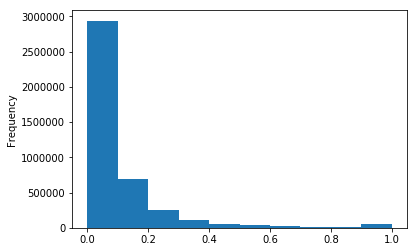

In [65]:
# get top 25% percentile demand locations
gdf.demand.plot.hist()

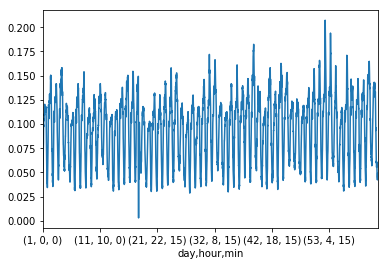

In [59]:
gdf.groupby(['day','hour','min']).demand.mean().plot()